# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.90923333
Average power, source: 1.0


Average magnitude, target: 0.8553287
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1974.9125, train_label_loss: 4.6196, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3930.0150, train_label_loss: 4.1876, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4027.4142, train_label_loss: 3.5192, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4025.6943, train_label_loss: 2.8488, 


epoch: 1, [batch: 18 / 45], examples_per_second: 3988.5077, train_label_loss: 2.5288, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3957.2156, train_label_loss: 2.1442, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4021.3148, train_label_loss: 1.8538, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4049.3648, train_label_loss: 1.8110, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4106.2966, train_label_loss: 1.6702, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4162.5009, train_label_loss: 1.5955, 


epoch: 1, source_val_acc_label: 0.7712, target_val_acc_label: 0.7079, source_val_label_loss: 1.4131, target_val_label_loss: 1.6553, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 497.2390, train_label_loss: 1.2839, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3995.0918, train_label_loss: 1.1727, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4090.2358, train_label_loss: 1.3283, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4087.7312, train_label_loss: 1.2261, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4080.3767, train_label_loss: 0.9835, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4041.6035, train_label_loss: 1.2913, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4136.9562, train_label_loss: 1.2404, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4137.0755, train_label_loss: 0.8966, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4172.7929, train_label_loss: 0.8594, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4232.7915, train_label_loss: 1.0818, 


epoch: 2, source_val_acc_label: 0.8308, target_val_acc_label: 0.7699, source_val_label_loss: 0.9340, target_val_label_loss: 1.2729, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 494.7388, train_label_loss: 1.0586, 


epoch: 3, [batch: 5 / 45], examples_per_second: 3991.3704, train_label_loss: 0.8720, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4092.1743, train_label_loss: 0.7415, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4091.4451, train_label_loss: 0.9470, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4091.6661, train_label_loss: 0.6145, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4043.2111, train_label_loss: 0.6484, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4143.2559, train_label_loss: 0.6583, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4146.8860, train_label_loss: 0.7516, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4179.7828, train_label_loss: 0.7370, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4237.4329, train_label_loss: 0.5880, 


epoch: 3, source_val_acc_label: 0.8705, target_val_acc_label: 0.7953, source_val_label_loss: 0.6658, target_val_label_loss: 1.0975, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 494.4246, train_label_loss: 0.7797, 


epoch: 4, [batch: 5 / 45], examples_per_second: 3984.2745, train_label_loss: 0.6898, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4080.4454, train_label_loss: 0.7324, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4085.8651, train_label_loss: 0.7499, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4088.4248, train_label_loss: 0.5034, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4028.6711, train_label_loss: 0.4422, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4119.6014, train_label_loss: 0.5628, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4131.7509, train_label_loss: 0.3467, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4168.1766, train_label_loss: 0.5542, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4236.9357, train_label_loss: 0.4026, 


epoch: 4, source_val_acc_label: 0.8917, target_val_acc_label: 0.8171, source_val_label_loss: 0.5017, target_val_label_loss: 0.9741, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 489.5513, train_label_loss: 0.4439, 


epoch: 5, [batch: 5 / 45], examples_per_second: 3985.9405, train_label_loss: 0.5370, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4089.4459, train_label_loss: 0.2912, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4085.1256, train_label_loss: 0.5796, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4093.7981, train_label_loss: 0.5310, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4035.9172, train_label_loss: 0.5659, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4140.4212, train_label_loss: 0.3834, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4136.7915, train_label_loss: 0.4578, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4170.7144, train_label_loss: 0.3505, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4219.6870, train_label_loss: 0.4375, 


epoch: 5, source_val_acc_label: 0.9231, target_val_acc_label: 0.8263, source_val_label_loss: 0.4050, target_val_label_loss: 0.9337, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 485.5085, train_label_loss: 0.3089, 


epoch: 6, [batch: 5 / 45], examples_per_second: 3974.1528, train_label_loss: 0.2951, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4081.0349, train_label_loss: 0.2258, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4091.4230, train_label_loss: 0.2753, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4072.1504, train_label_loss: 0.2190, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4022.0086, train_label_loss: 0.3536, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4136.8291, train_label_loss: 0.3352, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4130.5130, train_label_loss: 0.3142, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4133.9596, train_label_loss: 0.1789, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4228.4864, train_label_loss: 0.2142, 


epoch: 6, source_val_acc_label: 0.9442, target_val_acc_label: 0.8429, source_val_label_loss: 0.3294, target_val_label_loss: 0.8551, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 492.7806, train_label_loss: 0.4200, 


epoch: 7, [batch: 5 / 45], examples_per_second: 3963.7970, train_label_loss: 0.2693, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4072.5230, train_label_loss: 0.2945, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4078.5241, train_label_loss: 0.2243, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4070.1777, train_label_loss: 0.2472, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4019.8393, train_label_loss: 0.3317, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4119.9329, train_label_loss: 0.2223, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4113.7272, train_label_loss: 0.3049, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4158.3452, train_label_loss: 0.1677, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4218.9687, train_label_loss: 0.4558, 


epoch: 7, source_val_acc_label: 0.9500, target_val_acc_label: 0.8481, source_val_label_loss: 0.2966, target_val_label_loss: 0.8203, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 488.2873, train_label_loss: 0.2953, 


epoch: 8, [batch: 5 / 45], examples_per_second: 3945.3780, train_label_loss: 0.1482, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4070.8234, train_label_loss: 0.2533, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4074.9006, train_label_loss: 0.1964, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4069.8617, train_label_loss: 0.2802, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4019.0724, train_label_loss: 0.1861, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4120.4497, train_label_loss: 0.2128, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4131.6992, train_label_loss: 0.2665, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4169.0842, train_label_loss: 0.1685, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4217.8640, train_label_loss: 0.3054, 


epoch: 8, source_val_acc_label: 0.9590, target_val_acc_label: 0.8470, source_val_label_loss: 0.2689, target_val_label_loss: 0.8218, 


epoch: 9, [batch: 1 / 45], examples_per_second: 503.5877, train_label_loss: 0.2141, 


epoch: 9, [batch: 5 / 45], examples_per_second: 3962.4374, train_label_loss: 0.2194, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4066.5517, train_label_loss: 0.1505, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4070.2564, train_label_loss: 0.2406, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4072.8911, train_label_loss: 0.2393, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4015.0890, train_label_loss: 0.2079, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4127.9082, train_label_loss: 0.1062, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4121.9215, train_label_loss: 0.2645, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4162.0551, train_label_loss: 0.1458, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4204.7398, train_label_loss: 0.0760, 


epoch: 9, source_val_acc_label: 0.9615, target_val_acc_label: 0.8517, source_val_label_loss: 0.2440, target_val_label_loss: 0.7921, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 487.1197, train_label_loss: 0.2605, 


epoch: 10, [batch: 5 / 45], examples_per_second: 3978.3500, train_label_loss: 0.1544, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4080.3828, train_label_loss: 0.2166, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4074.0968, train_label_loss: 0.1748, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4077.1274, train_label_loss: 0.1142, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4027.1905, train_label_loss: 0.1872, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4132.4633, train_label_loss: 0.1974, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4131.1905, train_label_loss: 0.0908, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4167.4617, train_label_loss: 0.2183, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4214.2390, train_label_loss: 0.1025, 


epoch: 10, source_val_acc_label: 0.9609, target_val_acc_label: 0.8498, source_val_label_loss: 0.2452, target_val_label_loss: 0.7995, 


epoch: 11, [batch: 1 / 45], examples_per_second: 503.8871, train_label_loss: 0.2325, 


epoch: 11, [batch: 5 / 45], examples_per_second: 3974.9886, train_label_loss: 0.1287, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4073.0995, train_label_loss: 0.1373, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4069.5455, train_label_loss: 0.1236, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4061.6989, train_label_loss: 0.0686, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4009.5819, train_label_loss: 0.1013, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4119.1423, train_label_loss: 0.1299, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4116.7150, train_label_loss: 0.1064, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4141.6955, train_label_loss: 0.0984, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4222.7344, train_label_loss: 0.2376, 


epoch: 11, source_val_acc_label: 0.9622, target_val_acc_label: 0.8571, source_val_label_loss: 0.2272, target_val_label_loss: 0.7839, 


New best


epoch: 12, [batch: 1 / 45], examples_per_second: 486.5735, train_label_loss: 0.1432, 


epoch: 12, [batch: 5 / 45], examples_per_second: 3975.1625, train_label_loss: 0.2046, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4053.4723, train_label_loss: 0.1508, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4068.6297, train_label_loss: 0.1394, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4023.6799, train_label_loss: 0.1584, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4004.2970, train_label_loss: 0.2116, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4085.7610, train_label_loss: 0.1237, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4117.2450, train_label_loss: 0.1819, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4164.3896, train_label_loss: 0.1235, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4218.1724, train_label_loss: 0.1278, 


epoch: 12, source_val_acc_label: 0.9654, target_val_acc_label: 0.8596, source_val_label_loss: 0.2266, target_val_label_loss: 0.7597, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 488.6550, train_label_loss: 0.1071, 


epoch: 13, [batch: 5 / 45], examples_per_second: 3954.6765, train_label_loss: 0.1412, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4063.9860, train_label_loss: 0.2962, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4064.3280, train_label_loss: 0.0764, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4075.2670, train_label_loss: 0.1348, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4028.9271, train_label_loss: 0.1865, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4131.9591, train_label_loss: 0.1973, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4130.2142, train_label_loss: 0.1193, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4167.9943, train_label_loss: 0.0899, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4212.4223, train_label_loss: 0.0916, 


epoch: 13, source_val_acc_label: 0.9654, target_val_acc_label: 0.8605, source_val_label_loss: 0.2203, target_val_label_loss: 0.7753, 


New best


epoch: 14, [batch: 1 / 45], examples_per_second: 487.6229, train_label_loss: 0.1694, 


epoch: 14, [batch: 5 / 45], examples_per_second: 3964.4310, train_label_loss: 0.0524, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4066.5987, train_label_loss: 0.1916, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4067.7834, train_label_loss: 0.0733, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4067.1614, train_label_loss: 0.0893, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4021.7321, train_label_loss: 0.1128, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4124.2348, train_label_loss: 0.2458, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4120.9199, train_label_loss: 0.1525, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4162.6194, train_label_loss: 0.1574, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4219.8716, train_label_loss: 0.1036, 


epoch: 14, source_val_acc_label: 0.9692, target_val_acc_label: 0.8654, source_val_label_loss: 0.2044, target_val_label_loss: 0.7667, 


New best


epoch: 15, [batch: 1 / 45], examples_per_second: 491.1524, train_label_loss: 0.0454, 


epoch: 15, [batch: 5 / 45], examples_per_second: 3973.0538, train_label_loss: 0.1593, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4072.9428, train_label_loss: 0.2313, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4067.3113, train_label_loss: 0.1158, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4081.2456, train_label_loss: 0.2299, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4019.0867, train_label_loss: 0.0895, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4123.0887, train_label_loss: 0.1169, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4123.7685, train_label_loss: 0.1930, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4162.4987, train_label_loss: 0.2894, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4211.1193, train_label_loss: 0.0571, 


epoch: 15, source_val_acc_label: 0.9647, target_val_acc_label: 0.8660, source_val_label_loss: 0.2155, target_val_label_loss: 0.7654, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 484.4050, train_label_loss: 0.1592, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3974.2744, train_label_loss: 0.1230, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4068.6227, train_label_loss: 0.0601, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4062.8986, train_label_loss: 0.1204, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4076.4248, train_label_loss: 0.0688, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4011.7414, train_label_loss: 0.0739, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4121.4728, train_label_loss: 0.0748, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4115.8480, train_label_loss: 0.1927, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4154.6596, train_label_loss: 0.1116, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4208.8699, train_label_loss: 0.0913, 


epoch: 16, source_val_acc_label: 0.9654, target_val_acc_label: 0.8650, source_val_label_loss: 0.2096, target_val_label_loss: 0.7504, 


epoch: 17, [batch: 1 / 45], examples_per_second: 504.2173, train_label_loss: 0.0896, 


epoch: 17, [batch: 5 / 45], examples_per_second: 3967.0457, train_label_loss: 0.0841, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4062.1271, train_label_loss: 0.1310, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4072.3016, train_label_loss: 0.1035, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4078.3990, train_label_loss: 0.1323, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4012.3554, train_label_loss: 0.0780, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4121.6940, train_label_loss: 0.0561, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4124.8385, train_label_loss: 0.0713, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4152.9331, train_label_loss: 0.1474, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4218.7566, train_label_loss: 0.0457, 


epoch: 17, source_val_acc_label: 0.9660, target_val_acc_label: 0.8645, source_val_label_loss: 0.2101, target_val_label_loss: 0.7629, 


epoch: 18, [batch: 1 / 45], examples_per_second: 505.0252, train_label_loss: 0.1045, 


epoch: 18, [batch: 5 / 45], examples_per_second: 3959.2236, train_label_loss: 0.1317, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4079.2320, train_label_loss: 0.0276, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4070.5772, train_label_loss: 0.1947, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4071.0711, train_label_loss: 0.1183, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4009.2081, train_label_loss: 0.0663, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4115.0435, train_label_loss: 0.0879, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4123.5081, train_label_loss: 0.1754, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4149.2647, train_label_loss: 0.0416, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4204.2114, train_label_loss: 0.0751, 


epoch: 18, source_val_acc_label: 0.9692, target_val_acc_label: 0.8669, source_val_label_loss: 0.2020, target_val_label_loss: 0.7466, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 488.7041, train_label_loss: 0.1169, 


epoch: 19, [batch: 5 / 45], examples_per_second: 3975.9263, train_label_loss: 0.1345, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4068.5969, train_label_loss: 0.0995, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4076.0253, train_label_loss: 0.0666, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4067.1447, train_label_loss: 0.1256, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4009.3874, train_label_loss: 0.1017, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4119.4131, train_label_loss: 0.0731, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4107.7799, train_label_loss: 0.0474, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4160.2819, train_label_loss: 0.1606, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4214.8188, train_label_loss: 0.0956, 


epoch: 19, source_val_acc_label: 0.9705, target_val_acc_label: 0.8665, source_val_label_loss: 0.2071, target_val_label_loss: 0.7530, 


epoch: 20, [batch: 1 / 45], examples_per_second: 502.1068, train_label_loss: 0.0378, 


epoch: 20, [batch: 5 / 45], examples_per_second: 3963.3216, train_label_loss: 0.0851, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4062.0908, train_label_loss: 0.1113, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4059.5446, train_label_loss: 0.1009, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4060.0128, train_label_loss: 0.0565, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4007.1303, train_label_loss: 0.0557, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4107.9904, train_label_loss: 0.0938, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4117.4502, train_label_loss: 0.1514, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4140.2074, train_label_loss: 0.0654, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4219.6021, train_label_loss: 0.0975, 


epoch: 20, source_val_acc_label: 0.9686, target_val_acc_label: 0.8682, source_val_label_loss: 0.2063, target_val_label_loss: 0.7489, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 489.0971, train_label_loss: 0.0508, 


epoch: 21, [batch: 5 / 45], examples_per_second: 3975.4508, train_label_loss: 0.1257, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4072.7633, train_label_loss: 0.0305, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4067.9000, train_label_loss: 0.0502, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4073.0082, train_label_loss: 0.0886, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4016.3631, train_label_loss: 0.0374, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4128.6193, train_label_loss: 0.1491, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4123.0155, train_label_loss: 0.0301, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4162.4694, train_label_loss: 0.0947, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4214.3660, train_label_loss: 0.0701, 


epoch: 21, source_val_acc_label: 0.9712, target_val_acc_label: 0.8705, source_val_label_loss: 0.2042, target_val_label_loss: 0.7617, 


New best


epoch: 22, [batch: 1 / 45], examples_per_second: 489.9847, train_label_loss: 0.1401, 


epoch: 22, [batch: 5 / 45], examples_per_second: 3971.5114, train_label_loss: 0.1313, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4073.2669, train_label_loss: 0.1061, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4081.9132, train_label_loss: 0.0619, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4073.6929, train_label_loss: 0.1320, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4020.5672, train_label_loss: 0.1187, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4132.1986, train_label_loss: 0.0652, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4124.9010, train_label_loss: 0.0558, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4162.1619, train_label_loss: 0.1396, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4216.7762, train_label_loss: 0.0670, 


epoch: 22, source_val_acc_label: 0.9692, target_val_acc_label: 0.8720, source_val_label_loss: 0.1909, target_val_label_loss: 0.7376, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 486.7428, train_label_loss: 0.0662, 


epoch: 23, [batch: 5 / 45], examples_per_second: 3963.5435, train_label_loss: 0.0487, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4069.8799, train_label_loss: 0.0799, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4063.7695, train_label_loss: 0.0450, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4064.0118, train_label_loss: 0.0559, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4007.8537, train_label_loss: 0.0259, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4126.8194, train_label_loss: 0.1446, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4124.1662, train_label_loss: 0.0402, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4167.3177, train_label_loss: 0.1328, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4211.4234, train_label_loss: 0.0281, 


epoch: 23, source_val_acc_label: 0.9712, target_val_acc_label: 0.8718, source_val_label_loss: 0.2018, target_val_label_loss: 0.7502, 


epoch: 24, [batch: 1 / 45], examples_per_second: 500.6871, train_label_loss: 0.0616, 


epoch: 24, [batch: 5 / 45], examples_per_second: 3963.6990, train_label_loss: 0.1439, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4063.8800, train_label_loss: 0.1101, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4052.4411, train_label_loss: 0.1418, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4068.5210, train_label_loss: 0.0985, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4011.8571, train_label_loss: 0.0458, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4120.9044, train_label_loss: 0.0950, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4111.2628, train_label_loss: 0.0716, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4154.4152, train_label_loss: 0.1469, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4206.4266, train_label_loss: 0.0843, 


epoch: 24, source_val_acc_label: 0.9686, target_val_acc_label: 0.8746, source_val_label_loss: 0.1926, target_val_label_loss: 0.7420, 


New best


epoch: 25, [batch: 1 / 45], examples_per_second: 490.6320, train_label_loss: 0.0755, 


epoch: 25, [batch: 5 / 45], examples_per_second: 3976.7077, train_label_loss: 0.1343, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4067.0310, train_label_loss: 0.2230, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4065.3693, train_label_loss: 0.0591, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4073.8284, train_label_loss: 0.0943, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4029.3153, train_label_loss: 0.0375, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4124.2801, train_label_loss: 0.1255, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4120.1243, train_label_loss: 0.0671, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4161.1353, train_label_loss: 0.1783, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4216.4534, train_label_loss: 0.0847, 


epoch: 25, source_val_acc_label: 0.9673, target_val_acc_label: 0.8718, source_val_label_loss: 0.2171, target_val_label_loss: 0.7445, 


epoch: 26, [batch: 1 / 45], examples_per_second: 503.5973, train_label_loss: 0.1049, 


epoch: 26, [batch: 5 / 45], examples_per_second: 3969.9253, train_label_loss: 0.0430, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4057.5097, train_label_loss: 0.0411, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4068.9576, train_label_loss: 0.1228, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4065.2571, train_label_loss: 0.0781, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4014.3842, train_label_loss: 0.1099, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4127.6363, train_label_loss: 0.1700, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4117.0834, train_label_loss: 0.0544, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4150.5205, train_label_loss: 0.0960, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4216.2773, train_label_loss: 0.1024, 


epoch: 26, source_val_acc_label: 0.9692, target_val_acc_label: 0.8737, source_val_label_loss: 0.2001, target_val_label_loss: 0.7338, 


epoch: 27, [batch: 1 / 45], examples_per_second: 499.7374, train_label_loss: 0.1175, 


epoch: 27, [batch: 5 / 45], examples_per_second: 3966.0112, train_label_loss: 0.0233, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4057.9310, train_label_loss: 0.0425, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4061.2112, train_label_loss: 0.1583, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4071.8053, train_label_loss: 0.0582, 


epoch: 27, [batch: 23 / 45], examples_per_second: 3994.4102, train_label_loss: 0.0586, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4123.1137, train_label_loss: 0.0639, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4120.6941, train_label_loss: 0.0614, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4158.5088, train_label_loss: 0.0823, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4209.8838, train_label_loss: 0.0288, 


epoch: 27, source_val_acc_label: 0.9699, target_val_acc_label: 0.8724, source_val_label_loss: 0.2070, target_val_label_loss: 0.7555, 


epoch: 28, [batch: 1 / 45], examples_per_second: 503.5830, train_label_loss: 0.0767, 


epoch: 28, [batch: 5 / 45], examples_per_second: 3958.3627, train_label_loss: 0.0790, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4054.5710, train_label_loss: 0.0544, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4064.4747, train_label_loss: 0.0621, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4077.1746, train_label_loss: 0.0624, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4024.0876, train_label_loss: 0.0180, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4122.4263, train_label_loss: 0.0717, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4122.8191, train_label_loss: 0.1663, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4159.5468, train_label_loss: 0.0319, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4217.6683, train_label_loss: 0.0250, 


epoch: 28, source_val_acc_label: 0.9686, target_val_acc_label: 0.8699, source_val_label_loss: 0.1908, target_val_label_loss: 0.7546, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

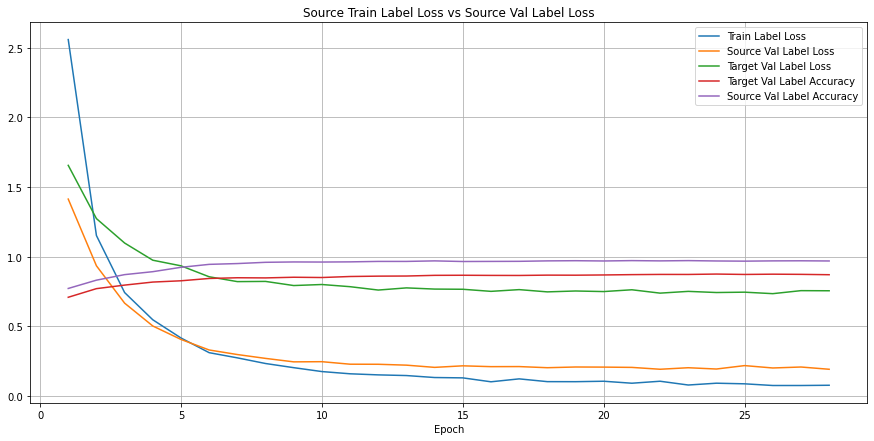

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

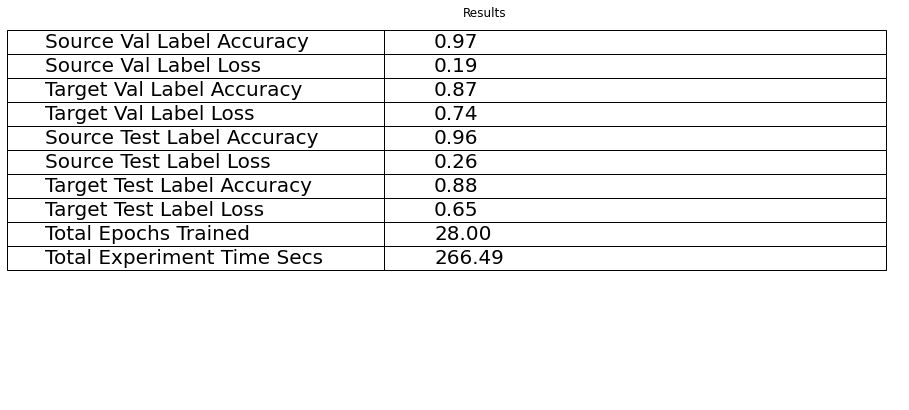

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

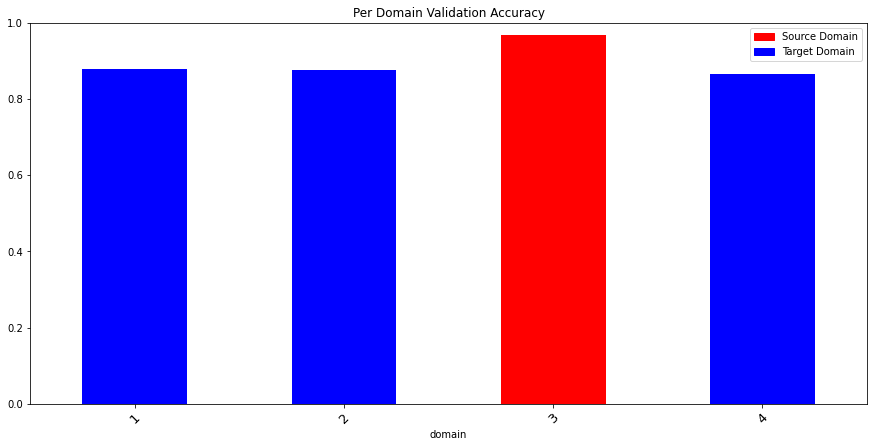

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.958974358974359 Target Test Label Accuracy: 0.879059829059829
Source Val Label Accuracy: 0.9685897435897436 Target Val Label Accuracy: 0.8745726495726496


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "